In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset, Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Artem\AppData\Local\Temp\ipykernel_20588\1986613272.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
naive_LSTM = Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

In [4]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.001

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''


# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)


model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
naive_LSTM.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 LSTM1 (LSTM)                (None, 15, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 LSTM2 (LSTM)                (None, 15, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 LSTM3 (LSTM)                (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0   

In [5]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])


Epoch 1/20
9/9 [==============================] - 13s 345ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 2/20
9/9 [==============================] - 1s 74ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 3/20
9/9 [==============================] - 1s 90ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 4/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 5/20
9/9 [==============================] - 1s 85ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 6/20
9/9 [==============================] - 1s 81ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 7/20
9/9 [============================

In [6]:
my_portfolio = Portfolio(origination_date=(val_idx[0] - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(val_idx[0] - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(val_idx[0] - tmpdelta(days=1)),
                                note = 'Initial deposit' )

ref_portfolio = Portfolio(origination_date=(val_idx[0] - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(val_idx[0] - tmpdelta(days=1)))
ref_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(val_idx[0] - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [7]:
#pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=14):])

In [24]:


def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))

for today in val_idx[naive_LSTM.input_span-1:]:
    tmr = today + tmpdelta(days=1)
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

my_portfolio.update_value(up_to=pred_df.index[-1])
ref_portfolio.update_value(up_to=pred_df.index[-1])

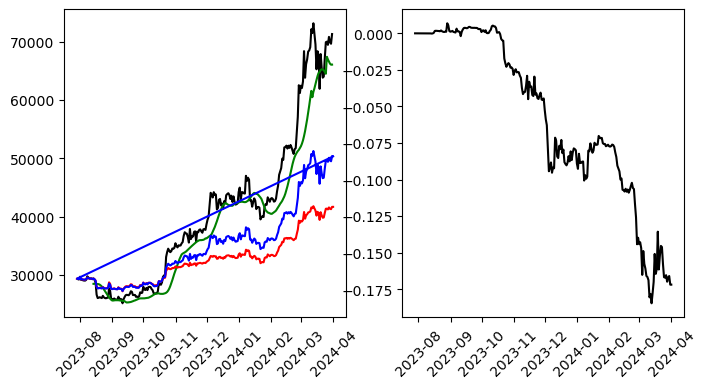

In [32]:
# Plot the results
fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)
actual_df = BTC.history.loc[val_idx]
ax[0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0].plot(pred_df.index, pred_df['Predicted price'], color = 'green', label = 'Predicted')
ax[0].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experimental Portfolio')
ax[0].plot(ref_portfolio.value.index, ref_portfolio.value['value'], color = 'blue', label = 'Reference Portfolio')
for tick in ax[0].get_xticklabels():
        tick.set_rotation(45)

ax[1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - ref_portfolio.value['value'])/ref_portfolio.value['value'], color = 'black', label = 'ROI')
for tick in ax[1].get_xticklabels():
        tick.set_rotation(45)

In [21]:
pred_df

,Predicted price
date_time,
2023-08-14 20:00:00,32014.216797
2023-08-15 20:00:00,32026.798828
2023-08-16 20:00:00,32004.515625
2023-08-17 20:00:00,31991.855469
2023-08-18 20:00:00,31938.332031
...,...
2024-03-26 20:00:00,66987.101562
2024-03-27 20:00:00,66672.289062
2024-03-28 20:00:00,66339.312500
